In [26]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [50]:
## Set up logging, device and seed
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

seed = 69
torch.manual_seed(seed)

2024-09-16 10:04:29,345 - INFO - Using device: cpu


In [28]:
## Load and Preprocess Data

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
codebook = pd.read_csv('codebook.csv')

logger.info("Data loaded successfully")
logger.info("Original Training data shape: %s", str(train_data.shape))
logger.info("Original Predication data shape: %s", str(test_data.shape))

X = train_data.drop(columns=['target'])
y = train_data['target']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.33, random_state=seed)

logger.info("Shape of Train data: %s", str(X_train.shape))
logger.info("Shape of Validation data: %s", str(X_val.shape))
logger.info("Shape of Test data: %s", str(X_test.shape))

# Normalize data?
# TODO
def normalize_data(data):
    return (data - data.mean()) / data.std()


# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

2024-09-16 09:45:40,730 - INFO - Data loaded successfully
2024-09-16 09:45:40,732 - INFO - Original Training data shape: (20132, 160)
2024-09-16 09:45:40,733 - INFO - Original Predication data shape: (5034, 159)
2024-09-16 09:45:40,917 - INFO - Shape of Train data: (14092, 159)
2024-09-16 09:45:40,919 - INFO - Shape of Validation data: (4046, 159)
2024-09-16 09:45:40,921 - INFO - Shape of Test data: (1994, 159)


In [52]:
## Define the Neural Network

# hier hebben we echt veel opties, dus ik heb simpele ffn gekopieerd van deep learning course

class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    

# Large neural network with dropout and batch normalization
# "what do you mean it overfits lol"
class LargeNN(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(LargeNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        if x is None:
            logger.debug("Error after fc1 and bn1")
        
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        if x is None:
            logger.debug("Error after fc2 and bn2")
        
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        if x is None:
            logger.debug("Error after fc3 and bn3")
        
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        if x is None:
            logger.debug("Error after fc4 and bn4")
        
        x = self.dropout(x)
        x = self.fc5(x)
        if x is None:
            logger.debug("Error after fc5")
        
        x = self.sigmoid(x)
        return x


In [57]:
# Define hyperparameters
batch_size = 64
nEpochs = 100 # deze sws wel omhoog maar ff voor snelheid nu :)
learning_rate = 0.001

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
# model = FeedforwardNN(input_dim).to(device)
model = LargeNN(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
## Define the training and evaluation functions
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)

            logger.debug(f"Model output shape: {outputs.shape}")
            logger.debug(f"Label shape: {labels.shape}")

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        # Calculate training accuracy for this epoch
        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        
        # Validation accuracy at the end of each epoch
        val_preds, val_labels = evaluate_model(model, val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        logger.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    return train_accuracies, val_accuracies

        
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds).flatten(), np.array(all_labels).flatten()


2024-09-16 10:06:15,839 - INFO - Epoch 1/100, Loss: 0.5397, Train Accuracy: 0.7751, Validation Accuracy: 0.7899
2024-09-16 10:06:17,788 - INFO - Epoch 2/100, Loss: 0.5010, Train Accuracy: 0.7897, Validation Accuracy: 0.7899
2024-09-16 10:06:19,399 - INFO - Epoch 3/100, Loss: 0.4935, Train Accuracy: 0.7897, Validation Accuracy: 0.7899
2024-09-16 10:06:21,132 - INFO - Epoch 4/100, Loss: 0.4859, Train Accuracy: 0.7898, Validation Accuracy: 0.7899
2024-09-16 10:06:23,368 - INFO - Epoch 5/100, Loss: 0.4800, Train Accuracy: 0.7897, Validation Accuracy: 0.7899
2024-09-16 10:06:24,953 - INFO - Epoch 6/100, Loss: 0.4715, Train Accuracy: 0.7900, Validation Accuracy: 0.7899
2024-09-16 10:06:26,566 - INFO - Epoch 7/100, Loss: 0.4663, Train Accuracy: 0.7902, Validation Accuracy: 0.7902
2024-09-16 10:06:28,478 - INFO - Epoch 8/100, Loss: 0.4583, Train Accuracy: 0.7927, Validation Accuracy: 0.7887
2024-09-16 10:06:30,117 - INFO - Epoch 9/100, Loss: 0.4511, Train Accuracy: 0.7945, Validation Accuracy:

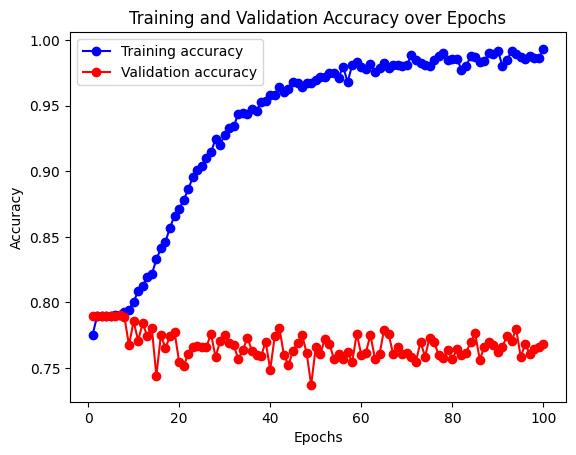

In [58]:
def plot_accuracies(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
    
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


# Train the model
train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=nEpochs)

# Plot the training and validation accuracy
plot_accuracies(train_accuracies, val_accuracies)

2024-09-15 17:04:30,491 - INFO - Validation Accuracy: 0.7884
2024-09-15 17:04:30,585 - INFO - Test Accuracy: 0.7874
2024-09-15 17:04:30,602 - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88      1573
         1.0       0.33      0.01      0.01       421

    accuracy                           0.79      1994
   macro avg       0.56      0.50      0.45      1994
weighted avg       0.69      0.79      0.70      1994



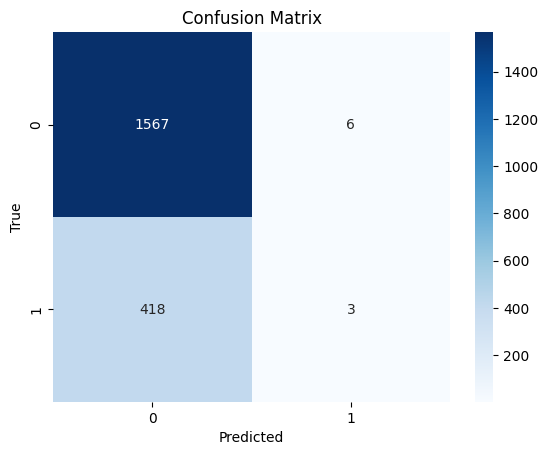

In [25]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Prepare test data
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate on validation set
val_preds, val_labels = evaluate_model(model, val_loader)
logger.info(f"Validation Accuracy: {accuracy_score(val_labels, val_preds):.4f}")

# Evaluate on test set
test_preds, test_labels = evaluate_model(model, test_loader)
logger.info(f"Test Accuracy: {accuracy_score(test_labels, test_preds):.4f}")

# Print classification report
logger.info(f"Classification Report:\n{classification_report(test_labels, test_preds)}")

# Plot confusion matrix for test set
plot_confusion_matrix(test_labels, test_preds)


In [ ]:
# Hier nog ff wat toevoegen zodat ons model ook de test data kan voorspellen en in predictions.txt zet